In [1]:
from pathlib import Path
import os
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from nilearn import image
from scipy.spatial.distance import euclidean, correlation,squareform
from nilearn.glm.thresholding import threshold_stats_img
from nilearn import plotting
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from os.path import join as opj

/home/javi/Documentos/software/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
final_subjects = np.loadtxt("../../data/subjects_intersect_motion_035.txt")
mask_img = "../../data/masks/grey_mask_motion_035.nii.gz"
results_dir = "../../results/second-level"

In [13]:
def load_results(task_id, contrast, mask_img, height_control="fdr", alpha = 0.05, cluster_threshold = 50):
    
    base_dir = opj("../../results/second-level/node_gsr/task-%s" % task_id, contrast)
    
    res_second = dict()
    for name in ["stat", "z_score", "p_value", "effect_size"]:
        res_second[name] = image.load_img(opj(base_dir, "%s.nii.gz" % name))
        
    z_thr, thr = threshold_stats_img(res_second["z_score"],  
                                     mask_img = mask_img,
                                     height_control = height_control,
                                     alpha = alpha,
                                     cluster_threshold = cluster_threshold)
    res_second['z_score_thr'] = z_thr
    
    res_second['stat_thr'] = image.math_img("img1*(abs(img2) > 0)",
                                            img1 = res_second["stat"], 
                                            img2 = z_thr)
    res_second['is_significant'] =  image.math_img("abs(img2) > 0", 
                                            img2 = z_thr)
    return res_second

In [4]:
from nilearn.masking import apply_mask
from scipy.stats import norm

In [5]:
def pearsonr_boot_ci(x, y, n_boots = 1000, alpha=0.05, random_state = 0):
    
    from scipy import stats
    
    np.random.seed(random_state)
    r, p = stats.pearsonr(x,y)
    n_obs = len(y)
    idxs = np.arange(n_obs)
    
    r_boots = []
    for i_boot in tqdm(range(n_boots)):
        boot_idxs = np.random.choice(idxs, size=n_obs)
        r_boots.append(np.corrcoef(x[boot_idxs], y[boot_idxs])[0,1])
        
    lo, hi = np.quantile(r_boots, q=[alpha/2, 1-alpha/2])
    
    return r, p, lo, hi

In [347]:
stroop_second = load_results(task_id = "stroop", 
                             contrast = "Incongruent-Congruent",
                             mask_img = mask_img, height_control = "bonferroni", cluster_threshold = 50)
msit_second = load_results(task_id = "msit", 
                           contrast = "Incongruent-Congruent",
                           mask_img = mask_img, height_control = "bonferroni", cluster_threshold = 50)

In [355]:
# Save surface plots
output_dir = "../../plots/surface_plots/voxel_level/task-stroop"
Path(output_dir).mkdir(exist_ok=True, parents=True)
for hemi in ['left', 'right']:
    if hemi=="left":
        big_texture = surface.vol_to_surf(stroop_second['stat_thr'], big_fsaverage.pial_left)
        surf_mesh = big_fsaverage.infl_left
        bg_map = big_fsaverage.sulc_left
    else:
        big_texture = surface.vol_to_surf(stroop_second['stat_thr'], big_fsaverage.pial_right)
        surf_mesh = big_fsaverage.infl_right
        bg_map = big_fsaverage.sulc_right
    
    for view in views:
        filename = "stat_voxel_bonf05_" + "hemi_%s" % hemi + "_view_%s" % view + ".png"
        output_file = output_dir + "/" + filename
        fig = plt.figure(figsize=(10,10))
        plotting.plot_surf_stat_map(surf_mesh,
                                    big_texture, hemi=hemi, colorbar=False, view=view,
                                    threshold=3., bg_map=bg_map, 
                                    vmax=21,
                                    figure=fig, output_file=output_file)

        
filename = "stat_voxel_bonf05_vol_axial_cuts.svg"
output_file = output_dir + "/" + filename
plotting.plot_stat_map(stroop_second['stat_thr'], 
                       cut_coords=(-10,0,10), 
                       threshold=3.,
                       display_mode='z', 
                       vmax=21, 
                       output_file=output_file)

<IPython.core.display.Javascript object>

In [356]:
# Save surface plots
output_dir = "../../plots/surface_plots/voxel_level/task-msit"
Path(output_dir).mkdir(exist_ok=True, parents=True)
for hemi in ['left', 'right']:
    if hemi=="left":
        big_texture = surface.vol_to_surf(msit_second['stat_thr'], big_fsaverage.pial_left)
        surf_mesh = big_fsaverage.infl_left
        bg_map = big_fsaverage.sulc_left
    else:
        big_texture = surface.vol_to_surf(msit_second['stat_thr'], big_fsaverage.pial_right)
        surf_mesh = big_fsaverage.infl_right
        bg_map = big_fsaverage.sulc_right
    
    for view in views:
        filename = "stat_voxel_bonf05_" + "hemi_%s" % hemi + "_view_%s" % view + ".png"
        output_file = output_dir + "/" + filename
        fig = plt.figure(figsize=(10,10))
        plotting.plot_surf_stat_map(surf_mesh,
                                    big_texture, hemi=hemi, colorbar=False, view=view,
                                    threshold=3., bg_map=bg_map, 
                                    vmax=21,
                                    figure=fig, output_file=output_file)

        
filename = "stat_voxel_bonf05_vol_axial_cuts.svg"
output_file = output_dir + "/" + filename
plotting.plot_stat_map(msit_second['stat_thr'], 
                       cut_coords=(-10,0,10), 
                       threshold=3.,
                       display_mode='z',
                       vmax=21,
                       output_file=output_file)

<IPython.core.display.Javascript object>

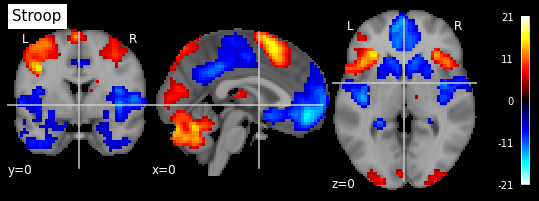

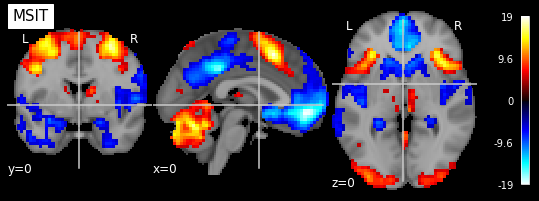

In [115]:
plotting.plot_stat_map(stroop_second['stat_thr'], 
                       title = "Stroop",  
                       cut_coords = (0, 0,0), 
                       colorbar=True, black_bg=True)
plt.savefig("../../plots/second-level/node/task-stroop/cuts_incongruent_congruent_bonf05_k50.png", dpi=300)
plt.savefig("../../plots/second-level/node/task-stroop/cuts_incongruent_congruent_bonf05_k50.svg", dpi=300)
plt.savefig("../../plots/second-level/node/task-stroop/cuts_incongruent_congruent_bonf05_k50.pdf", dpi=300)

plotting.plot_stat_map(msit_second['stat_thr'], 
                       title = "MSIT",  
                       cut_coords = (0, 0, 0), 
                       colorbar=True, black_bg=True)

plt.savefig("../../plots/second-level/node/task-msit/cuts_incongruent_congruent_bonf05_k50.png", dpi=300)
plt.savefig("../../plots/second-level/node/task-msit/cuts_incongruent_congruent_bonf05_k50.svg", dpi=300)
plt.savefig("../../plots/second-level/node/task-msit/cuts_incongruent_congruent_bonf05_k50.pdf", dpi=300)

In [33]:
stroop_first = apply_mask(["../../results/first-level/node_gsr/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz" % subj \
                           for subj in final_subjects], mask_img="../../data/masks/group_level_mask.nii.gz")
msit_first = apply_mask(["../../results/first-level/node_gsr/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz" % subj \
                           for subj in final_subjects], mask_img="../../data/masks/group_level_mask.nii.gz")

In [101]:
from scipy.stats import ttest_rel
res = [ttest_rel(a, b) for a,b in zip(stroop_first.T, msit_first.T)]
res = np.array(res)

t_diff_img = unmask(res[:,0], mask_img="../../data/masks/group_level_mask.nii.gz")
z_diff = np.array([np.sign(a)*norm.isf(b) for a,b in res])
z_diff_img = unmask(z_diff, mask_img="../../data/masks/group_level_mask.nii.gz")

In [74]:
from statsmodels.stats.multitest import multipletests

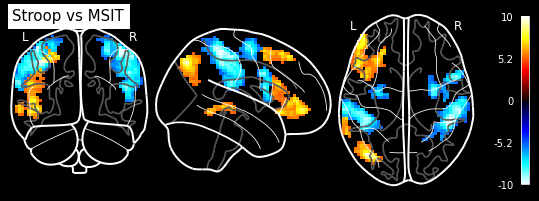

In [114]:
from scipy.stats import norm
from nilearn.plotting import cm
from nilearn.glm import threshold_stats_img
from nilearn.image import math_img
z_diff_thr,_ = threshold_stats_img(z_diff_img, 
                                   alpha=0.05,
                                   height_control='bonferroni',
                                   cluster_threshold=50)

plotting.plot_glass_brain(math_img("img1*(abs(img2)>0)",
                                   img1=t_diff_img, 
                                   img2=z_diff_thr),  
                                   cmap=cm.cold_hot,
                          colorbar=True, plot_abs=False, symmetric_cbar=True, alpha=1, 
                         title="Stroop vs MSIT", black_bg=True)

plt.savefig("../../plots/second-level/node/diff_tasks_incongruent_congruent_bonf05_k50.png", dpi=300)
plt.savefig("../../plots/second-level/node/diff_tasks_incongruent_congruent_bonf05_k50.svg", dpi=300)
plt.savefig("../../plots/second-level/node/diff_tasks_incongruent_congruent_bonf05_k50.pdf", dpi=300)

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'MSIT T-stats')

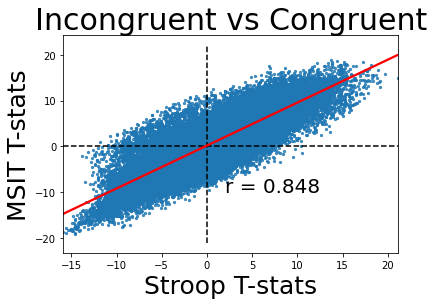

In [116]:
r_stats = np.corrcoef(apply_mask(stroop_second['stat'], mask_img), 
                      apply_mask(msit_second['stat'], mask_img))[0,1]
sns.regplot(apply_mask(stroop_second['stat'], mask_img), apply_mask(msit_second['stat'], mask_img), 
            scatter_kws={"s": 5}, line_kws={"color": "red"})
ymin, ymax = plt.gca().get_ylim()
xmin, xmax = plt.gca().get_xlim()
plt.vlines(x = 0, ymin=ymin, ymax = ymax, linestyles="dashed", color="black")
plt.hlines(y = 0, xmin=xmin, xmax = xmax, linestyles="dashed", color="black")
plt.text(x = 2, y = -10, s = "r = %.3f" % r_stats, size=20)
plt.title("Incongruent vs Congruent", size=30)
plt.xlabel("Stroop T-stats", size=25)
plt.ylabel("MSIT T-stats", size=25)

In [12]:
from scipy.spatial.distance import dice
1-dice(apply_mask(stroop_second['is_significant'], mask_img), apply_mask(msit_second['is_significant'], mask_img))

0.7045614414804393

In [240]:

def map_on_atlas(stat_data, atlas_img):
    """
    Function to map a statistical map
    """
    from nilearn import image
    atlas_img = image.load_img(atlas_img)
    n_rois = len(np.unique(atlas_img.get_fdata()))-1
    stat_data = np.squeeze(stat_data)
    if stat_data.ndim > 1:
        raise ValueError("input stat data should be a vector")
    if len(stat_data) != n_rois:
        raise ValueError("stat componentes do not match"
                         " the number of ROIS of the atlas")
    atlas_img_data = atlas_img.get_fdata()
    stat_on_atlas = np.zeros_like(atlas_img_data)
    
    for ii in range(n_rois):
        stat_on_atlas[atlas_img_data==(ii+1)] = stat_data[int(ii)]
    
    stat_on_atlas_img = image.new_img_like(atlas_img, stat_on_atlas)
    return stat_on_atlas_img


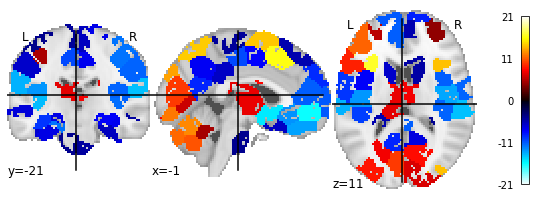

In [242]:
plotting.plot_stat_map(map_on_atlas(t_stroop*((pvals_stroop*bonf)<0.05), 
                                    atlas_img="../../data/atlases/shen_2mm_268_parcellation.nii.gz"))

In [258]:
print(np.corrcoef(t_stroop, t_msit)[0,1])
print(1-dice(pvals_stroop<0.05/bonf, pvals_msit<0.05/bonf))

0.8825471446253004
0.847953216374269


In [338]:
df = 242-1
n_rois = 268
atlas_img="../../data/atlases/shen_2mm_268_parcellation.nii.gz"

bonf = n_rois*2*2 # the number of regions x two-sided tests x {Stroop & MSIT}

views = ["lateral", "medial", "dorsal", "ventral", "anterior", "posterior"]
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [344]:
z_stroop = np.squeeze(image.load_img("../../results/second-level/node_gsr_shen/task-stroop/Incongruent-Congruent/z_score.nii.gz").get_fdata())
t_stroop = np.squeeze(image.load_img("../../results/second-level/node_gsr_shen/task-stroop/Incongruent-Congruent/stat.nii.gz").get_fdata())
cohen_stroop = t_stroop/np.sqrt(df)
pvals_stroop_bonf = norm.sf(abs(z_stroop))*bonf
mask = (pvals_stroop_bonf<0.05)
t_stroop_shen_bonf = map_on_atlas(t_stroop*mask, atlas_img= atlas_img)
t_stroop_shen_bonf.to_filename("../../results/second-level/node_gsr_shen/task-stroop/Incongruent-Congruent/stat_voxel_bonf05.nii.gz")
mask = (pvals_stroop_bonf<0.05) & (abs(cohen_stroop) > 0.5)
t_stroop_shen_bonf_cohen = map_on_atlas(t_stroop*mask, atlas_img= atlas_img)
t_stroop_shen_bonf_cohen.to_filename("../../results/second-level/node_gsr_shen/task-stroop/Incongruent-Congruent/stat_voxel_bonf05_d05.nii.gz")

# Save surface plots
output_dir = "../../plots/surface_plots/task-stroop"
Path(output_dir).mkdir(exist_ok=True, parents=True)
for hemi in ['left', 'right']:
    if hemi=="left":
        big_texture = surface.vol_to_surf(t_stroop_shen_bonf, big_fsaverage.pial_left)
        surf_mesh = big_fsaverage.infl_left
        bg_map = big_fsaverage.sulc_left
    else:
        big_texture = surface.vol_to_surf(t_stroop_shen_bonf, big_fsaverage.pial_right)
        surf_mesh = big_fsaverage.infl_right
        bg_map = big_fsaverage.sulc_right
    
    for view in views:
        filename = "stat_voxel_bonf05_" + "hemi_%s" % hemi + "_view_%s" % view + ".png"
        output_file = output_dir + "/" + filename
        fig = plt.figure(figsize=(10,10))
        plotting.plot_surf_stat_map(surf_mesh,
                                    big_texture, hemi=hemi, colorbar=False, view=view,
                                    threshold=3., bg_map=bg_map, 
                                    figure=fig, output_file=output_file)
        
filename = "stat_voxel_bonf05_vol_axial_cuts.svg"
output_file = output_dir + "/" + filename
plotting.plot_stat_map(t_stroop_shen_bonf, 
                       cut_coords=(-10,0,10), 
                       threshold=3.,
                       display_mode='z', 
                       output_file=output_file)

<IPython.core.display.Javascript object>

In [346]:
z_msit = np.squeeze(image.load_img("../../results/second-level/node_gsr_shen/task-msit/Incongruent-Congruent/z_score.nii.gz").get_fdata())
t_msit = np.squeeze(image.load_img("../../results/second-level/node_gsr_shen/task-msit/Incongruent-Congruent/stat.nii.gz").get_fdata())
cohen_msit = t_msit/np.sqrt(df)
pvals_msit_bonf = norm.sf(abs(z_msit))*bonf
mask = (pvals_msit_bonf<0.05)
t_msit_shen_bonf = map_on_atlas(t_msit*mask, atlas_img = atlas_img)
t_msit_shen_bonf.to_filename("../../results/second-level/node_gsr_shen/task-msit/Incongruent-Congruent/stat_voxel_bonf05.nii.gz")
mask = (pvals_msit_bonf<0.05) & (abs(cohen_msit) > 0.5)
t_msit_shen_bonf_cohen = map_on_atlas(t_msit*mask, atlas_img= atlas_img)
t_msit_shen_bonf_cohen.to_filename("../../results/second-level/node_gsr_shen/task-msit/Incongruent-Congruent/stat_voxel_bonf05_d05.nii.gz")

# Save surface plots
output_dir = "../../plots/surface_plots/task-msit"
Path(output_dir).mkdir(exist_ok=True, parents=True)
for hemi in ['left', 'right']:
    if hemi=="left":
        big_texture = surface.vol_to_surf(t_msit_shen_bonf, big_fsaverage.pial_left)
        surf_mesh = big_fsaverage.infl_left
        bg_map = big_fsaverage.sulc_left
    else:
        big_texture = surface.vol_to_surf(t_msit_shen_bonf, big_fsaverage.pial_right)
        surf_mesh = big_fsaverage.infl_right
        bg_map = big_fsaverage.sulc_right
    
    for view in views:
        filename = "stat_voxel_bonf05_" + "hemi_%s" % hemi + "_view_%s" % view + ".png"
        output_file = output_dir + "/" + filename
        fig = plt.figure(figsize=(10,10))
        plotting.plot_surf_stat_map(surf_mesh,
                                    big_texture, hemi=hemi, colorbar=False, view=view,
                                    threshold=3., bg_map=bg_map, 
                                    figure=fig, output_file=output_file)

        
filename = "stat_voxel_bonf05_vol_axial_cuts.svg"
output_file = output_dir + "/" + filename
plotting.plot_stat_map(t_msit_shen_bonf, 
                       cut_coords=(-10,0,10), 
                       threshold=3.,
                       display_mode='z', 
                       output_file=output_file)

<IPython.core.display.Javascript object>

## Get activation peaks (positive and negative), to be later used as seed for connectivity


In [8]:
import json

In [9]:
def get_peaks(img):
    img_data = img.get_fdata()
    
    pos_peak_coords = np.where(img_data == np.max(img_data))
    pos_peak_coords = tuple(np.concatenate(pos_peak_coords)) # Convert to tuple
    
    neg_peak_coords = np.where(img_data == np.min(img_data))
    neg_peak_coords = tuple(np.concatenate(neg_peak_coords)) # Convert to tuple
    
    # Convert this to physical coordinates
    pos_peak_coords_mni = image.coord_transform(*pos_peak_coords, affine=img.affine)
    neg_peak_coords_mni = image.coord_transform(*neg_peak_coords, affine=img.affine)
    peaks_mni = {'positive': pos_peak_coords_mni,  'negative': neg_peak_coords_mni}
    return peaks_mni

In [56]:
stroop_second['stat_thr'].get_fdata().max()

18.264145598682884

In [10]:
peaks_stroop = get_peaks(stroop_second['stat_thr'])
print(peaks_stroop)
with open("../results/second-level/node/task-stroop/Incongruent-Congruent/peaks.json", "w") as f:
    json.dump(peaks_stroop, f)
    
peaks_msit = get_peaks(msit_second['stat_thr'])
print(peaks_msit)
with open("../results/second-level/node/task-msit/Incongruent-Congruent/peaks.json", "w") as f:
    json.dump(peaks_msit, f)

{'positive': (-42.04899883270264, 5.229002952575684, 29.5), 'negative': (-0.40999794006347656, 46.868003845214844, -12.5)}
{'positive': (2.793002128601074, -65.23699855804443, -21.5), 'negative': (-3.6129980087280273, 46.868003845214844, -12.5)}


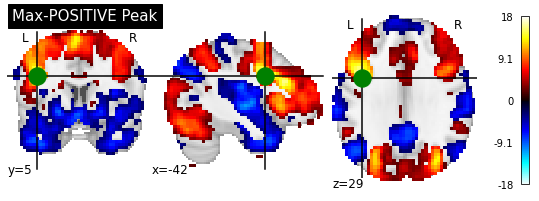

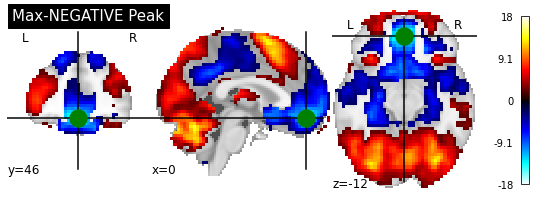

In [11]:
display = plotting.plot_stat_map(stroop_second['stat_thr'], 
                                 cut_coords = peaks_stroop['positive'], title="Max-POSITIVE Peak")
display.add_markers(marker_coords=[peaks_stroop['positive']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.pdf", dpi=300)

display = plotting.plot_stat_map(stroop_second['stat_thr'], 
                                 cut_coords = peaks_stroop['negative'], title="Max-NEGATIVE Peak")
display.add_markers(marker_coords=[peaks_stroop['negative']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-stroop/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.pdf", dpi=300)

In [ ]:
display = plotting.plot_stat_map(msit_second['stat_thr'], 
                                 cut_coords = peaks_msit['positive'], title="Max-POSITIVE Peak")
display.add_markers(marker_coords=[peaks_msit['positive']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_pos_peak.pdf", dpi=300)

display = plotting.plot_stat_map(msit_second['stat_thr'], 
                                 cut_coords = peaks_msit['negative'], title="Max-NEGATIVE Peak")
display.add_markers(marker_coords=[peaks_msit['negative']], marker_color='green',
                    marker_size=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.png", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.svg", dpi=300)
plt.savefig("../plots/second-level/node/task-msit/cuts_incongruent_congruent_fdr05_k50_max_neg_peak.pdf", dpi=300)